# Quatum Guayabita
Warning: This is a beta version, so is not intended to be "pretty", but rather to work!

In [47]:
#Libraries
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile,QuantumRegister,ClassicalRegister
from qiskit.circuit.quantumcircuit import string
import qiskit.quantum_info as qi
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import plot_histogram


# Notation
rng = np.random.default_rng() # numpy random number generator
simulator = QasmSimulator() # set qiskit quantum simulator: Aer's qasm_simulator

In [48]:
def Q_uniform_strategy(dice_result, player_money, bank_money,alpha, beta):
  
  """
  Q_uniform_strategy:
  Unitary implementation of the strategy_1 in the classical circuit.

  * Classical inputs:
  - dice_result:   First dice value in the round
  - player_money:  Player attribute (or bank attribute) counting the available money of the player
  - bank_money:    bank attribute counting the money in the game.

  * "Quantum" inputs:
     In the quantum case the strategy is now an unitary matrix given by, 
                 U=R_{z}(\alpha)R_{y}(-2\theta_{l})R_{z}(\beta).
     with R_{x},R_{z},R_{y} the usual rotation matrices (as implemented in Qiskit) and theta_{l} the rotation angles determined by the dice input.
    
    Pdta: Notice that in order to obtain interesting effects, we must enhance the interference between the phases, e.g \alpha \neq \beta.
  """
  
  # Define the step function according to the money available.
  aval = np.heaviside(player_money-bank_money, 0)  

  #define the rotation angles
  theta=np.arccos([np.sqrt(5.0/6),np.sqrt(4.0/6),np.sqrt(3.0/6),np.sqrt(2.0/6),np.sqrt(1.0/6),0.0])

  U_strategy=QuantumCircuit(1)
  

  if aval == 0:
    U_strategy.x(0) # if there is no enough money then gambling->No gambling
  else:
    U_strategy.rz(beta,0)
    U_strategy.ry(-2*theta[dice_result-1],0)
    U_strategy.rz(alpha,0)

  return U_strategy

#Example: if player_money>bank_money and dice_result=3, we want to have equal probabilities to gamble or not gamble.

Q_uniform_strategy(3,3,2,1,1).draw()


┌───────┐┌──────────┐┌───────┐
q: ┤ Rz(1) ├┤ Ry(-π/2) ├┤ Rz(1) ├
   └───────┘└──────────┘└───────┘

In [49]:
class Bank():

  def __init__(self, money_a, money_b, Bank_money):
    self.A_money = money_a
    self.B_money = money_b
    self.Bank_money = Bank_money

  def dice(self):
    face = np.random.randint(1,6) 
    parameter = ((face - 1)/5)*np.pi/2   
    return parameter



In [50]:
# Usual Bell entangler 
Entangler=QuantumCircuit(2)
Entangler.h(0)
Entangler.cnot(0,1)

#usual Bell disentangler
D_Entangler=QuantumCircuit(2)
D_Entangler.cnot(0,1)
D_Entangler.h(0)


In [57]:
def Round_call():
    alpha=np.pi/4
    beta=0

    player=QuantumRegister(2, "player")
    cr0=ClassicalRegister(1, "player1_wins")
    cr1=ClassicalRegister(1, "player1_loses")
    cr2=ClassicalRegister(1, "player2_win")
    cr3=ClassicalRegister(1, "player2_loses")  #here is the trick, I will use 4 classical registers!

    bank=Bank(0,0,0) #initialize the bank to an arbitrary value!
    Round=QuantumCircuit(player,cr0,cr1,cr2,cr3)  #initialize the circuit


    #Round.compose(Entangler,inplace=True)
    Round.barrier(0,1)

    A_dice1=rng.integers(1,7) #first outcome of Alice's dice
    A_dice2=rng.integers(1,7) #second outcome of Alice's dice

    B_dice1=rng.integers(1,7) #first outcome of Bob's dice
    B_dice2=rng.integers(1,7) #second outcome of Bob's dice


    # In the quantum case, the players can win or loose even if they hadn't played yet!

    A_qstrategy=Q_uniform_strategy(1,bank.A_money,bank.Bank_money,alpha,beta) #alice strategy
    AQS=qi.Operator(A_qstrategy)

    Round.unitary(AQS,qubits=[0],label="player_1_strategy")
    Round.barrier(0,1)

    """
    Here we are going to do the following trick: in order to distinguish between the win or lose cases when we are reading the counts, we are going to codify the win/lose cases as follows:
    *) if player win ==> the classical bit in the first register of the player is going to be opposite to the classical bit in the second register
    *) if player lose ===> the classical bit in the first register of the player is going to be equal to the one the classical bit on the second register 
    """


    if A_dice1<A_dice2: #Won!
    
        Round.measure(player[0],cr0[0]) # store the Won outcome in the first classical register
        #As this is the win case we must negate the measure and store in the second classical register
        Round.x(player[0])
        Round.measure(player[0],cr1[0]) 
        Round.barrier(0,1)
   
        #Now, If Alice won, Bob strategy is determined by one of the following Bank states:
        #-) [A_money+bank_money,B_money,0] ~ Alice Won by gambling all (AWG)
        #-) [A_money+1,B_money,Bank_money-1] ~ Alice Won by Not Gambling (AWNG)
    
  
        B_qstrategy1=Q_uniform_strategy(B_dice1,bank.B_money,0,alpha,beta) #Bob first strategy
        B_qstrategy2=Q_uniform_strategy(B_dice1,bank.B_money,bank.Bank_money-1,alpha,beta) #Bob second strategy
    
        BQS1, BQS2 = qi.Operator(B_qstrategy1), qi.Operator(B_qstrategy2) #Pass strategies to unitaries to use the c_if later
    
        Round.unitary(BQS1,qubits=[1],label="player1_strategy").c_if(cr0, 0)
        Round.unitary(BQS2,qubits=[1], label="player1_strategy").c_if(cr0, 1)  

        Round.barrier(0,1)
        if B_dice1<B_dice2:
            Round.measure(player[1],cr2[0]) #measure the second player  winning gambling outcome in the third qubit
            Round.x(player[1])
            Round.measure(player[1],cr3[0])
        else:
            Round.measure(player[1],cr3[0]) #measure the second player  losing gambling outcome in the four qubit
            Round.measure(player[1],cr2[0])
    


    else: #lose!
   
        Round.measure(player[0],cr1[0]) # store the lose in the second classical register
        #As this is the lose case both the first and second classical registers must be the same
        Round.measure(player[0],cr0[0]) 
        Round.barrier(0,1)
   
        #  Now, If Alice lose, Bob strategy is determined by one of the following Bank states:
        #  -) [A_money-bank_money,B_money,2*bank_money] ~ Alice Lose by Gambling all (ALG)
        # -) [A_money-1,B_money,Bank_money+1] ~ Alice Lose by No Gambling (ALNG)
   
        B_qstrategy3=Q_uniform_strategy(B_dice1,bank.B_money,2*bank.Bank_money,alpha,beta) #Bob third strategy
        B_qstrategy4=Q_uniform_strategy(B_dice1,bank.B_money,bank.Bank_money+1,alpha,beta) #Bob fourth strategy

        BQS3, BQS4 = qi.Operator(B_qstrategy3), qi.Operator(B_qstrategy4)

        Round.unitary(BQS3,qubits=[1],label="player2_strategy").c_if(cr1, 0)
        Round.unitary(BQS4,qubits=[1],label="player2_strategy").c_if(cr1, 1)  

        Round.barrier(0,1)
        if B_dice1<B_dice2:
            Round.measure(player[1],cr2[0]) #measure the second player  winning gambling outcome in the third qubit
            Round.x(player[1])
            Round.measure(player[1],cr3[0])
        else:
            Round.measure(player[1],cr3[0]) #measure the second player  losing gambling outcome in the four qubit
            Round.measure(player[1],cr2[0])
    Round.barrier(0,1)
    return(Round)
    

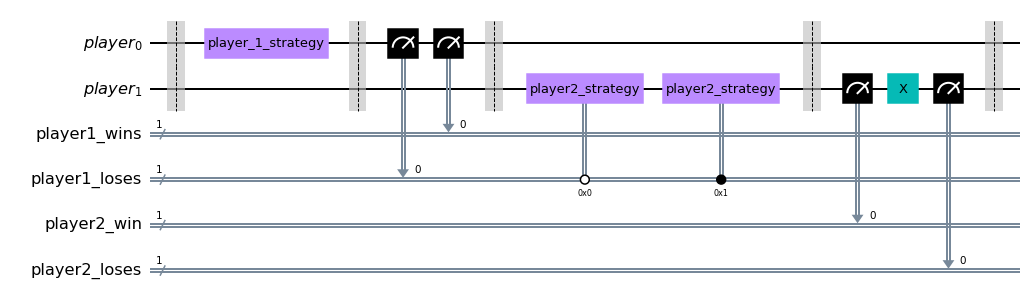

In [72]:
Round_call().draw("mpl")

In [52]:
def string_to_money(count):
    """"
    string_to_money: converts and outcome of the quantum simulation and turns in into an valid transaction on the bank
    -count: a classical binary string of length four, i.e "0011".
    """
    count=count[::2] # eliminate the odd spaces in the count format, i.e "0 0 1 0"->"0010"
    
#===================Check the first player==============================#

    if int(count[2])^int(count[3])==1: # the first player win!

        if int(count[3])==0:#the first player win and bet all
            bank.A_money=bank.A_money+bank.Bank_money
            bank.Bank_money=0
        else: #the first player win and bet nothing
            bank.A_money=bank.A_money+1
            bank.Bank_money=bank.Bank_money-1
    else: #the first player lose

        if int(count[3])==0:#the first player lose and bet all
            bank.A_money=bank.A_money-bank.Bank_money
            bank.Bank_money=2*bank.Bank_money
        else: #the first player lose and bet nothing
            bank.A_money=bank.A_money-1
            bank.Bank_money=bank.Bank_money+1 




#===================Check the second player==============================#    
    
    if int(count[0])^int(count[1])==1: # the second player win!
        if int(count[1])==0:#the second player win and bet all
            bank.B_money=bank.B_money+bank.Bank_money
            bank.Bank_money=0
        else: #the second player win and bet nothing
            bank.B_money=bank.B_money+1
            bank.Bank_money=bank.Bank_money-1
    else: #the second player lose

        if int(count[1])==0:#the second player lose and bet all
            bank.B_money=bank.B_money-bank.Bank_money
            bank.Bank_money=2*bank.Bank_money
        else: #the second player lose and bet nothing
            bank.B_money=bank.B_money-1
            bank.Bank_money=bank.Bank_money+1 
         
           

1 0 0 1
0 1 1 1
1 1 1 1
1 0 0 1
1 1 1 1
1 1 0 1
1 1 1 1
0 1 1 1
1 0 0 1
0 1 1 1
1 1 1 1
0 0 0 1
0 1 1 1
1 1 0 1
0 1 1 1
1 1 1 1
1 1 0 1
1 1 0 1
1 1 1 1
0 1 1 1
1 0 0 1
1 1 0 1
1 0 0 1
1 1 0 1
1 1 1 1
0 1 0 1
1 1 1 1
1 1 1 1
1 1 0 1
1 1 1 1
0 1 1 1
0 1 1 1
1 1 0 1
0 1 1 1
0 1 1 1
0 1 1 1
0 1 1 1
1 1 0 1
1 1 0 1
0 1 0 1
1 1 1 1
0 0 0 1
0 1 1 1
0 0 0 1
1 1 1 1
1 1 1 1
1 1 0 1
1 1 1 1
0 0 0 1
1 1 1 1
0 1 1 1
1 1 0 1
1 1 0 1
0 1 1 1
1 1 1 1
0 1 1 1
1 1 1 1
1 1 1 1
1 1 0 1
1 1 1 1
0 1 1 1
1 1 1 1
1 1 1 1
1 0 0 1
1 1 1 1
1 1 1 1
0 1 1 1
1 0 0 1
1 1 1 1
0 1 1 1
0 1 1 1
0 1 1 1
0 1 1 1
1 1 1 1
0 1 1 1
1 1 1 1
1 1 1 1
1 1 1 1
1 0 0 1
1 1 1 1
1 0 0 1
1 1 1 1
1 1 1 1
1 1 0 1
1 1 0 1
1 1 1 1
1 1 1 1
1 0 0 1
1 1 1 1
1 0 0 1
1 0 0 1
0 1 1 1
0 1 1 1
0 1 1 1
0 1 1 1
1 0 0 1
1 0 0 1
1 1 0 1
1 1 0 1
0 1 0 1
0 1 1 1
1 1 1 1
0 1 1 1
1 1 1 1
0 1 0 1
1 0 0 1
1 1 1 1
1 1 1 1
1 1 0 1
0 1 1 1
1 1 0 1
0 1 1 1
0 1 1 1
1 1 1 1
1 0 0 1
0 1 1 1
1 0 0 1
1 1 1 1
0 1 0 1
0 0 0 1
1 1 0 1
1 1 0 1
1 1 1 1
0 1 0 1
1 1 1 1


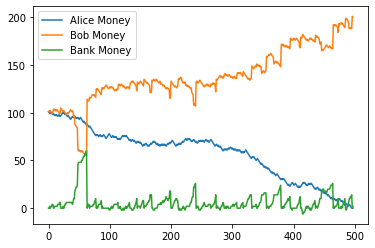

In [77]:
turns=2000

#initialize the bank
bank=Bank(100,100,2) #alice and bob money's

AliceM=[]
BobM=[]
tableM=[]

for i in range(turns):
    sample=Round_call()
    compiled_circuit = transpile(sample, simulator)
    job = simulator.run(compiled_circuit, shots=1)
    result = job.result()
    counts = result.get_counts(sample)

    for i in counts:
        x=i
        print(x)


    string_to_money(x)
    

    if ((bank.A_money<0) or (bank.B_money< 0)):
        break

    AliceM.append(bank.A_money)
    BobM.append(bank.B_money)
    tableM.append(bank.Bank_money)


plt.plot(AliceM, label="Alice Money")
plt.plot(BobM, label="Bob Money")
plt.plot(tableM, label="Bank Money")
#plt.plot(AliceM+BobM+tableM) #here is a mistake that i must check tomorrow
plt.legend()
#plt.plot(range(turns),BobM)



In [79]:
"""
This is an example that the count_to_money function works and conserves the money
"""
example="1 1 1 1"
bank=Bank(10,10,10)

print(bank.A_money,"+",bank.B_money,"+",bank.Bank_money,"=", bank.A_money+bank.B_money+bank.Bank_money)

string_to_money(example)

print(bank.A_money,"+",bank.B_money,"+",bank.Bank_money,"=", bank.A_money+bank.B_money+bank.Bank_money)

10 + 10 + 10 = 30
9 + 9 + 12 = 30
